In [270]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
from teneto import TemporalNetwork
import json
from collections import defaultdict
import warnings
from os import listdir
from tqdm import tqdm
import bz2
from os.path import isfile, join
from scipy import sparse
import pickle
import networkx as nx
import seaborn as sns

from multiprocessing import Queue, Process
warnings.filterwarnings("ignore")

<h2> Extract User to Subreddit Associations </h2>

In [271]:
n_cores = 100
PATH = "/mnt/erebor1/Daten/ABI2/crawls/dreddit/"  # path to comment folder
min_posts = 10

In [272]:
def is_relevant_title(title):
    return any(keyword in title.lower() for keyword in ["ukraine", "putin", "kyiv", "russia"]) 

In [414]:
def get_user_to_subreddit_associations():
    def run(qw, qm):
        worker_dict = {}
        subreddit_topic_counts = defaultdict(int)
        
        while True:
            file_path = qw.get()
            if file_path is None:
                break
            else:
                with bz2.open(file_path, "rt") as file:
                    for line in file:
                        comment = json.loads(line)
                        if comment.get("over_18"):
                            continue
                            
                        subreddit = comment.get("subreddit")
                        user_id = comment.get("author_fullname")
                        # user_name = comment.get("author")
                        
                        if user_id not in worker_dict:
                            worker_dict[user_id] = set([subreddit])
                        worker_dict[user_id].add(subreddit)
                        
                        link_title = comment.get("link_title")
                        if is_relevant_title(link_title):
                            subreddit_topic_counts[subreddit] += 1
                        
        qm.put((worker_dict, subreddit_topic_counts))
    
    queue_batches = Queue(n_cores)
    queue_results = Queue(n_cores)
    
    workers = [Process(target=run, args=(queue_batches, queue_results)) for _ in range(n_cores)]
    files =  [join(PATH + "comments/", f) for f in listdir(PATH + "comments/") 
              if isfile(join(PATH + "comments/", f))][:800]
    
    
    for w in workers:
        w.start()
    
    for i, f in enumerate(files):
        if i % 10 == 9:
            print("Batch Progress: {}%".format(round(100.*i / len(files), 1)), end="\r")
        queue_batches.put(f)
    
    for _ in range(n_cores):
        queue_batches.put(None)
        
    # merge results
    remaining_answers = n_cores
    
    sub_idx = {}
    usr_idx = {}
    
    rows = []
    cols = []
    
    topic_counts_per_subreddit = defaultdict(int)
    
    
    while remaining_answers > 0:
        partial_result, topic_counts = queue_results.get()
        for usr, subs in partial_result.items():
            if len(subs) < 2:
                continue

            if usr not in usr_idx:
                usr_idx[usr] = len(usr_idx)
                        
            for sub in subs:
                if sub not in sub_idx:
                    idx = len(sub_idx)
                    sub_idx[sub] = idx
                rows.append(sub_idx[sub])
                cols.append(usr_idx[usr])
        for sr, cnt in topic_counts.items():
            topic_counts_per_subreddit[sr] += cnt
                
                    
        remaining_answers -= 1
    
    sr2u = sparse.csr_matrix((np.ones(len(rows)), (rows, cols)), dtype=np.uint16)
    return sr2u, sub_idx, topic_counts_per_subreddit

sr2u, sub_idx, subreddit_topic_counts = get_user_to_subreddit_associations()
print(sr2u.shape)  # subreddits x users

#pickle.dump(sr2u, open("sr2u.pcl", "wb"))
#pickle.dump(sub_idx, open("sub_idx.pcl", "wb"))
#pickle.dump(subreddit_topic_counts, open("subreddit_topic_counts.pcl", "wb"))

(92857, 1366144)99.9%


Ergebnis ist eine Subreddit x User Liste

In [349]:
#sr2u = pickle.load(open("sr2u.pcl", "rb"))
#sub_idx = pickle.load(open("sub_idx.pcl", "rb"))

Aus dieser erzeugen wir eine SR x SR Matrix, wobei jeder Eintrag die Anzahl an Nutzern beinhaltet, welche in beiden SRs Beiträge verfasst haben

In [415]:
sr2u[sr2u > 0] = 1
pmat = sr2u * sr2u.T  # subreddits x subreddits
diag = pmat.diagonal()
pmat = pmat.todense()
print(pmat)

[[ 335    8    2 ...    0    0    0]
 [   8 3723   10 ...    0    0    0]
 [   2   10  915 ...    0    0    0]
 ...
 [   0    0    0 ...    1    0    0]
 [   0    0    0 ...    0    1    0]
 [   0    0    0 ...    0    0    1]]


<h3>Number of Posts within each Subreddit</h3>

In [103]:
sorted(zip(np.diag(pmat), sub_idx.keys()), reverse=True)

[(64561, 'news'),
 (63727, 'ukraine'),
 (62781, 'Cringetopia'),
 (62184, 'AmItheAsshole'),
 (59832, 'funny'),
 (58766, 'worldnews'),
 (58552, 'interestingasfuck'),
 (57993, 'teenagers'),
 (57012, 'Unexpected'),
 (52429, 'HolUp'),
 (51638, 'Eldenring'),
 (47524, 'unpopularopinion'),
 (45047, 'movies'),
 (44229, 'AskMen'),
 (44007, 'mildlyinteresting'),
 (42733, 'IdiotsInCars'),
 (40414, 'shitposting'),
 (39526, 'pics'),
 (39010, 'WhitePeopleTwitter'),
 (37856, 'relationship_advice'),
 (37557, 'technology'),
 (37392, 'NoStupidQuestions'),
 (36549, 'todayilearned'),
 (36293, 'Tinder'),
 (33833, 'TooAfraidToAsk'),
 (33666, 'aww'),
 (33489, 'wallstreetbets'),
 (32499, 'CombatFootage'),
 (31521, 'nba'),
 (31237, 'Showerthoughts'),
 (31124, 'pcmasterrace'),
 (30513, 'dankmemes'),
 (28027, 'cats'),
 (27570, 'UkrainianConflict'),
 (27435, 'oddlyterrifying'),
 (25848, 'science'),
 (25471, 'conspiracy'),
 (25239, 'oddlysatisfying'),
 (24879, 'nfl'),
 (24574, 'PoliticalHumor'),
 (24571, 'Wellthats

<h3>Raw Number of Subreddits associated with each Subreddit</h3>

In [104]:
sorted(zip(np.count_nonzero(np.asarray(pmat), axis=0) - 1, sub_idx.keys()), reverse=True)

[(59876, 'AskReddit'),
 (50260, 'interestingasfuck'),
 (50116, 'worldnews'),
 (47439, 'Damnthatsinteresting'),
 (46745, 'ukraine'),
 (45976, 'mildlyinfuriating'),
 (44941, 'nextfuckinglevel'),
 (44621, 'PublicFreakout'),
 (44547, 'memes'),
 (43659, 'antiwork'),
 (42689, 'Unexpected'),
 (41397, 'MadeMeSmile'),
 (41200, 'TrueOffMyChest'),
 (40984, 'facepalm'),
 (40879, 'Cringetopia'),
 (40782, 'gaming'),
 (39771, 'funny'),
 (39129, 'news'),
 (38406, 'BeAmazed'),
 (38162, 'teenagers'),
 (37472, 'politics'),
 (37442, 'shitposting'),
 (37279, 'HolUp'),
 (37134, 'IdiotsInCars'),
 (36414, 'MapPorn'),
 (36397, 'mildlyinteresting'),
 (36328, 'therewasanattempt'),
 (36316, 'unpopularopinion'),
 (36255, 'meirl'),
 (36039, 'PoliticalCompassMemes'),
 (36018, 'UkrainianConflict'),
 (35537, 'WhitePeopleTwitter'),
 (35443, 'movies'),
 (35381, 'Eldenring'),
 (35265, 'marvelmemes'),
 (35035, 'pics'),
 (34931, 'NoStupidQuestions'),
 (34906, 'AskMen'),
 (34562, 'wallstreetbets'),
 (34557, 'ThatsInsane'),


<h3>Curated Number of Subreddits associated with each Subreddit</h3>

Kuratierte SRxSR Matrix:

In [416]:
# pruning of absolute values
pmat[pmat < 100] = 0  
pmat = np.asarray(pmat)

subreddit_popularity = np.diag(pmat)  # keep user counts per subreddit
np.fill_diagonal(pmat, 0)  # exclude diagonal for relative importances

remove_idx = np.where(np.count_nonzero(pmat, axis=0) == 0)[0]
sub_idx = [k for k,v in sub_idx.items() if v not in remove_idx]
sub_idx = {k:i for i,k in enumerate(sub_idx)}

pmat = pmat[~np.all(pmat == 0, axis=1)]
pmat = pmat[:,~np.all(pmat == 0, axis=0)]
print(pmat)
print(pmat.shape)
pickle.dump(pmat, open("pmat.pcl", "wb"))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(3054, 3054)


In [106]:
pmat = pickle.load(open("pmat.pcl", "rb"))

In [417]:
# pruing of relative values
uniform_expected = np.diag(np.minimum(100000, np.count_nonzero(pmat, axis=0))/(2*np.sum(pmat, axis=0)))  # relevance threshold: uniform
print(np.sum(pmat, axis=0) / np.minimum(100, np.count_nonzero(pmat, axis=0)))  # relevance factor
print(np.minimum(100, np.count_nonzero(pmat, axis=0))/np.sum(pmat, axis=0))
pmat = np.matmul(uniform_expected, pmat)  # 1: uniform, <1: low relevance, >1: high relevance

#d = 1/sr2u.diagonal()
#pmat = np.multiply(pmat,d.reshape((-1,1)))

pmat

[144.   337.85 135.   ... 114.   102.   116.  ]
[0.00694444 0.00295989 0.00740741 ... 0.00877193 0.00980392 0.00862069]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [418]:
pmat[pmat < 1.] = 0
print(np.sum(pmat, axis=0))
print(np.count_nonzero(pmat, axis=0))
pmat = pmat * pmat.T  # relevant edges for both sides
pmat

[0.         1.24045166 0.         ... 0.         0.         0.        ]
[0 1 0 ... 0 0 0]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [419]:
remove_idx = np.where(np.count_nonzero(pmat, axis=0) == 0)[0]
sub_idx = [k for k,v in sub_idx.items() if v not in remove_idx]
sub_idx = {k:i for i,k in enumerate(sub_idx)}
idx2sub = {v:k for k,v in sub_idx.items()}

#subreddit_popularity = np.diag(pmat)  # keep user counts per subreddit

pmat = pmat[~np.all(pmat == 0, axis=1)]
pmat = pmat[:,~np.all(pmat == 0, axis=0)]
pmat.shape

(418, 418)

In [110]:
sorted(zip(np.count_nonzero(np.asarray(pmat), axis=0) - 1, sub_idx.keys()), reverse=True)

[(311, 'AskReddit'),
 (256, 'worldnews'),
 (235, 'interestingasfuck'),
 (194, 'Damnthatsinteresting'),
 (188, 'mildlyinfuriating'),
 (187, 'TrueOffMyChest'),
 (186, 'antiwork'),
 (181, 'nextfuckinglevel'),
 (176, 'gaming'),
 (170, 'facepalm'),
 (170, 'PublicFreakout'),
 (168, 'MadeMeSmile'),
 (162, 'Unexpected'),
 (152, 'news'),
 (152, 'Cringetopia'),
 (150, 'memes'),
 (147, 'funny'),
 (144, 'ukraine'),
 (141, 'politics'),
 (136, 'unpopularopinion'),
 (132, 'mildlyinteresting'),
 (131, 'HolUp'),
 (130, 'movies'),
 (130, 'WhitePeopleTwitter'),
 (126, 'IdiotsInCars'),
 (117, 'shitposting'),
 (117, 'pics'),
 (116, 'todayilearned'),
 (113, 'technology'),
 (111, 'AskMen'),
 (109, 'NoStupidQuestions'),
 (107, 'aww'),
 (103, 'teenagers'),
 (101, 'therewasanattempt'),
 (101, 'TooAfraidToAsk'),
 (100, 'oddlyterrifying'),
 (100, 'Tinder'),
 (100, 'Showerthoughts'),
 (98, 'oddlysatisfying'),
 (97, 'dankmemes'),
 (97, 'AmItheAsshole'),
 (96, 'science'),
 (95, 'BeAmazed'),
 (94, 'wallstreetbets'),


In [420]:
pmat = 1/pmat
pmat

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [421]:
pmat[pmat == np.inf] = 0
pmat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [422]:
#pmat = pmat > 0
A = sparse.csr_matrix(pmat)
#sparse.save_npz("adjacency_subreddits.npz", A)

In [114]:
pickle.dump(sub_idx, open("adjacency_sub_idx.pcl", "wb"))

In [254]:
A = sparse.load_npz("adjacency_subreddits.npz")

In [322]:
A.shape

(584, 584)

<h3> Which subreddits hold most of the comment traffic for a specific topic?</h3>

In [117]:
dict(sorted(subreddit_topic_counts.items(), key=lambda item: item[1], reverse=True))

{'worldnews': 3074930,
 'ukraine': 619463,
 'interestingasfuck': 338803,
 'UkrainianConflict': 289183,
 'CombatFootage': 284220,
 'UkraineWarVideoReport': 195425,
 'politics': 191299,
 'neoliberal': 185096,
 'Damnthatsinteresting': 178578,
 'europe': 175907,
 'PublicFreakout': 171197,
 'news': 147119,
 'nextfuckinglevel': 134085,
 'conspiracy': 118702,
 'AskARussian': 82302,
 'de': 74835,
 'NonCredibleDefense': 73533,
 'wallstreetbets': 55984,
 'AskReddit': 53436,
 'Conservative': 51752,
 'CryptoCurrency': 48987,
 'ThatsInsane': 41252,
 'soccer': 40022,
 'memes': 38816,
 'facepalm': 37928,
 'whereintheworld': 35061,
 'MapPorn': 33132,
 'CrazyFuckingVideos': 32149,
 'technology': 30792,
 'canada': 29083,
 'MadeMeSmile': 27211,
 'BeAmazed': 26587,
 'ukpolitics': 26519,
 'france': 25800,
 'RussiaPolitics': 25798,
 'unitedkingdom': 25086,
 'RussiaUkraineWar2022': 24993,
 'TrueOffMyChest': 24747,
 'formula1': 22023,
 'anime_titties': 21891,
 'Unexpected': 21853,
 'pics': 21437,
 'GenZedong'

In [423]:
stc_truncated = {k: np.log2(v+1) for k,v  in subreddit_topic_counts.items() if v > 0}
sum(subreddit_topic_counts.values())
print(len(subreddit_topic_counts), len(stc_truncated))

9825 9825


In [223]:
stc_truncated

{'europe': 17.42446157008283,
 'feetpics': 4.247927513443585,
 'SmartlandsPlatform': 6.459431618637297,
 'ukraine': 19.240660917366696,
 'memes': 15.244401002176813,
 'SubredditDrama': 13.129444023031947,
 'worldnews': 21.55212260674363,
 'ukpolitics': 14.69479315499995,
 'Wallstreetsilver': 13.680689169360203,
 'TankPorn': 14.29117069932186,
 'UkrainianConflict': 18.141628207364796,
 'conspiracy': 16.856996871341064,
 'dsrfunny': 7.294620748891627,
 'malaysia': 11.652396861477678,
 'pcmasterrace': 11.818582177480858,
 'news': 17.1666338592993,
 'MemeEconomy': 9.499845887083206,
 'macbookpro': 5.977279923499917,
 'AskReddit': 15.705551395471227,
 'AskOuija': 12.772108342052116,
 'korea': 11.135067945777816,
 'wallstreetbets': 15.772752718783936,
 'conspiracy_commons': 12.578844391558203,
 'eurovision': 11.733862719678543,
 'MilitaryPorn': 13.258124324938922,
 'warinukraine': 10.293471648838134,
 'yesyesyesyesno': 9.044394119358454,
 'FlightTracker': 10.458406613236534,
 'russia': 12.93

In [424]:
v_min = min(stc_truncated.values())
v_max = max(stc_truncated.values())
v_min, v_max

(1.0, 20.739888537622523)

In [425]:
stc_truncated = {k:(v-v_min)/(v_max-v_min) for k, v in stc_truncated.items()}

In [141]:
stc_truncated

{'europe': 0.8084797059623118,
 'feetpics': 0.1934809470188744,
 'SmartlandsPlatform': 0.29894705749737327,
 'ukraine': 0.8927500719239497,
 'memes': 0.7073254196416512,
 'SubredditDrama': 0.6091874820095561,
 'worldnews': 1.0,
 'ukpolitics': 0.6818232868167,
 'Wallstreetsilver': 0.6347671569629756,
 'TankPorn': 0.6630947358346437,
 'UkrainianConflict': 0.8417557724809133,
 'conspiracy': 0.7821496467899115,
 'dsrfunny': 0.3380364203747844,
 'malaysia': 0.5406404314318023,
 'pcmasterrace': 0.5483535509642616,
 'news': 0.7965166466414375,
 'MemeEconomy': 0.44069218689128514,
 'macbookpro': 0.276269606880573,
 'AskReddit': 0.7287228745697568,
 'AskOuija': 0.5926053127936365,
 'korea': 0.5166278405973938,
 'wallstreetbets': 0.7318410154027961,
 'conspiracy_commons': 0.583636659093263,
 'eurovision': 0.5444215195147226,
 'MilitaryPorn': 0.6151587752677131,
 'warinukraine': 0.4775549046682142,
 'yesyesyesyesno': 0.4195252371866531,
 'FlightTracker': 0.48521351226225745,
 'russia': 0.59999227

In [426]:
G = nx.from_numpy_matrix(A.todense(), create_using=nx.Graph())
G = nx.relabel_nodes(G, idx2sub)

# remove isolates and self edges
G.remove_nodes_from(list(nx.isolates(G)))


# restrict on largest connected component
connected_comp = sorted(nx.connected_components(G), key=lambda n:len(n), reverse=True)[0]
G = nx.subgraph(G, connected_comp)

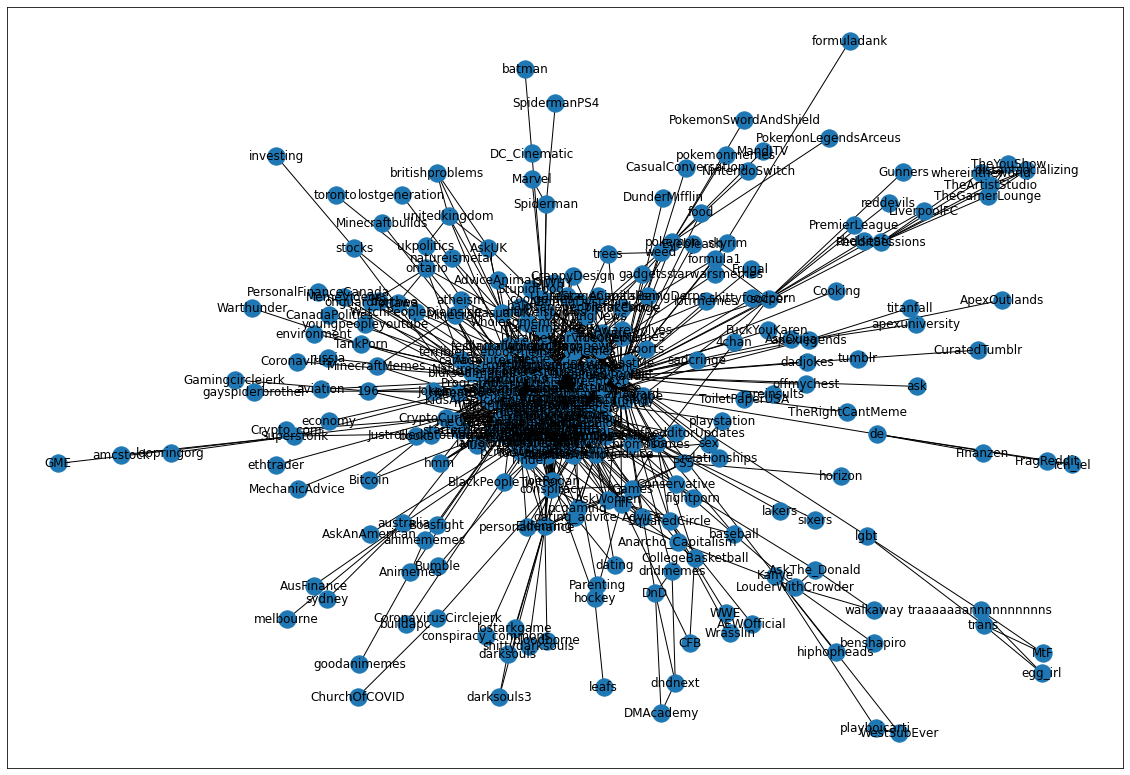

In [263]:
# plot the network
plt.figure(figsize=(20,14))

nx.draw_networkx(G)
plt.savefig("interest_map_raw.pdf")

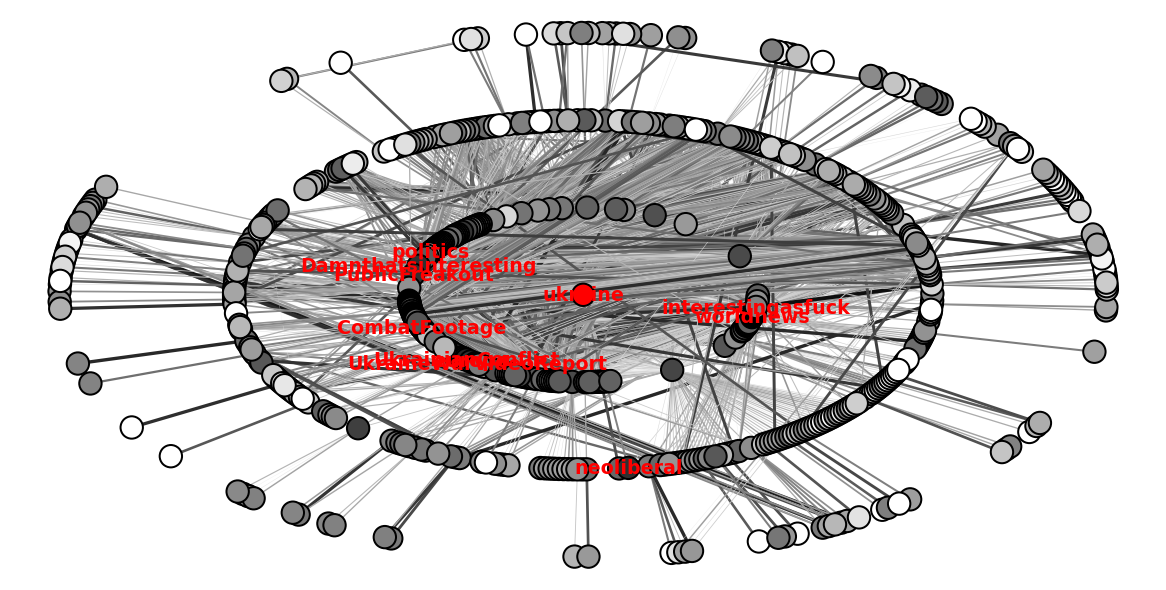

In [139]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

plt.figure(figsize=(16,8))

ego_network = nx.ego_graph(G, "ukraine")
nodes_ego1 = ego_network.nodes()
ego_network = nx.ego_graph(G, "ukraine", 3)


#pos = nx.spiral_layout(ego_network)  # Seed layout for reproducibility
#pos = nx.kamada_kawai_layout(ego_network)  # Seed layout for reproducibility
pos = graphviz_layout(ego_network, "twopi", "ukraine")  # Seed layout for reproducibility


weights = [ego_network[u][v]["weight"] for u,v in ego_network.edges()]


# weight and color of edges 
scaling_factor = 4 # to emphasise differences 
alphas = [weight * scaling_factor for weight in weights]
colors = [rgb_to_hex(tuple(np.repeat(int(255 * (1-weight)),3))) for weight in weights]

colormap = ["red" if node == "ukraine" else "lightgray" if node in nodes_ego1 else "white" for node in ego_network.nodes()]

# node colors weighted by comment counts
node_colors = [stc_truncated[node] if node in stc_truncated else 0 for node in ego_network.nodes()]
node_colors = [rgb_to_hex(tuple(np.repeat(int(255 * (1-color)),3))) for color in node_colors]

node_colors[list(ego_network.nodes()).index("ukraine")] = "red"

#labelsdict = {node:node if node in nodes_ego1 else "" for node in ego_network.nodes()}
labelsdict = {node:node if node in stc_truncated and stc_truncated[node] > 0.8 else "" for node in ego_network.nodes()}


nx.draw(ego_network, 
        pos,
        connectionstyle="arc3,rad=0.15",
        node_color=node_colors, 
        node_size=500, 
        with_labels=True, 
        linewidths=2,
        width=alphas, 
        edgecolors="black",
        font_weight="bold",
        font_size="19",
        font_color="red",
        labels=labelsdict,
       edge_color=colors)
#plt.savefig("ego_network_ukraine.pdf")

<h3>Kommentarvorkommen zum Thema in Abhängigkeit zur Distanz im Egonetzwerk</h3>

In [231]:
ego_distances = nx.shortest_path_length(nx.ego_graph(G, "ukraine", 3), "ukraine")
df = pd.DataFrame(columns=["counts", "ego_distance"])

for k,v in subreddit_topic_counts.items():
    if k not in ego_distances:
        continue
    if k == "ukraine":
        continue
    df = df.append({"counts": v, "ego_distance": ego_distances[k]}, ignore_index=True)
df["counts"] = df["counts"].apply(lambda n: np.log10(n))

In [232]:
df

,counts,ego_distance
0,5.245283,1
1,4.589011,1
2,3.952308,2
3,6.487835,1
4,4.423557,2
...,...,...
539,0.000000,3
540,2.429752,2
541,0.000000,3
542,0.301030,3


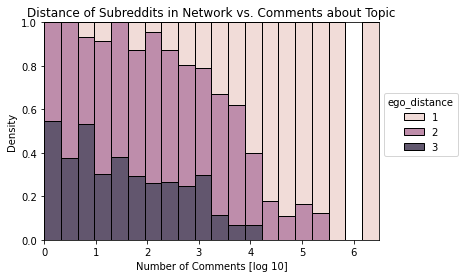

In [212]:
g = sns.histplot(df, x="counts", bins=20, hue="ego_distance", stat="density", multiple="fill")
g.legend_.set_bbox_to_anchor((1.0, .7))
plt.xlabel("Number of Comments [log 10]")
plt.title("Distance of Subreddits in Network vs. Comments about Topic")
plt.savefig("ego_distance_vs_comments_ukraine.pdf", bbox_inches="tight")

In [264]:
node_degrees = sorted([(v, k) for k, v in G.degree()], reverse=True, key=lambda n: n[0])

for v, k in node_degrees:
    print(k, v)

AskReddit 181
worldnews 149
interestingasfuck 131
Damnthatsinteresting 100
antiwork 92
gaming 90
mildlyinfuriating 89
nextfuckinglevel 87
PublicFreakout 85
facepalm 85
memes 84
TrueOffMyChest 82
news 77
MadeMeSmile 75
Cringetopia 74
Unexpected 74
funny 73
politics 71
HolUp 62
oddlyterrifying 61
pics 60
technology 58
WhitePeopleTwitter 58
unpopularopinion 58
IdiotsInCars 57
mildlyinteresting 57
movies 54
ukraine 52
shitposting 50
todayilearned 49
teenagers 48
therewasanattempt 47
Showerthoughts 47
AskMen 46
BeAmazed 46
aww 44
NoStupidQuestions 43
AmItheAsshole 42
TooAfraidToAsk 42
Tinder 41
PoliticalHumor 38
iamatotalpieceofshit 36
oddlysatisfying 36
nottheonion 36
dankmemes 36
Wellthatsucks 34
Whatcouldgowrong 33
science 32
CrazyFuckingVideos 32
wallstreetbets 32
pcmasterrace 32
LifeProTips 31
gifs 29
OldSchoolCool 29
awfuleverything 28
cats 27
WinStupidPrizes 26
ThatsInsane 25
relationship_advice 25
trashy 25
maybemaybemaybe 25
WTF 25
tifu 24
CombatFootage 24
meirl 24
europe 22
Leopar

In [143]:
def neighborhood(G, node, n):
    path_lengths = nx.single_source_dijkstra_path_length(G, node)
    return [(x, length) for x, length in path_lengths.items() if length <= n]

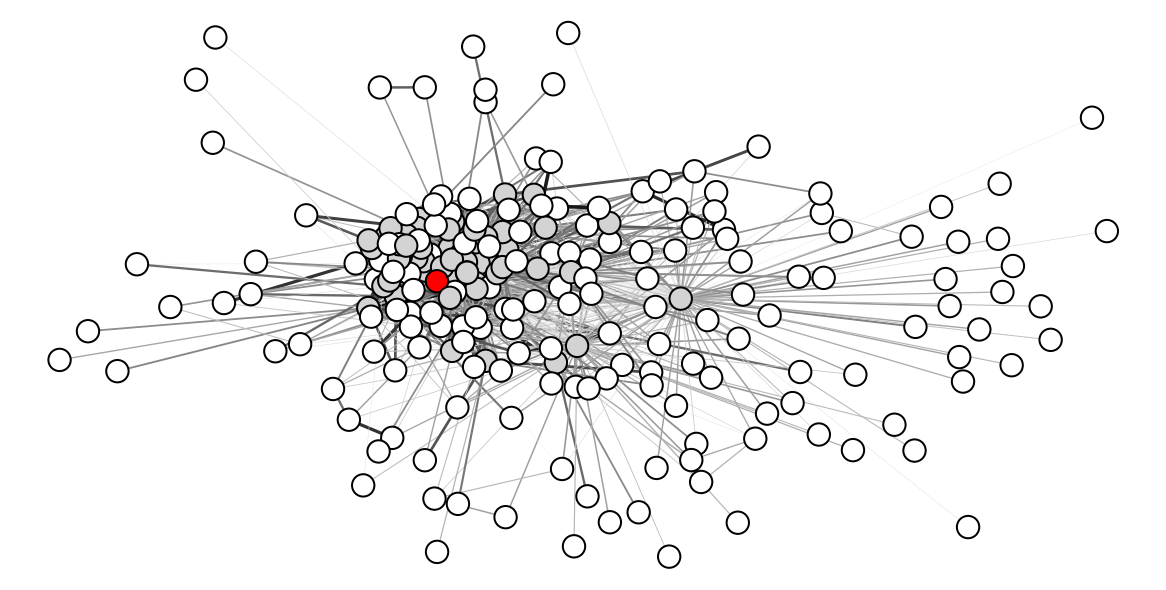

In [284]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

plt.figure(figsize=(16,8))

ego_network = nx.ego_graph(G, "ukraine")
nodes_ego1 = ego_network.nodes()
ego_network = nx.ego_graph(G, "ukraine", 2)


#pos = nx.spiral_layout(ego_network)  # Seed layout for reproducibility
#pos = nx.kamada_kawai_layout(ego_network)  # Seed layout for reproducibility
weights = [ego_network[u][v]["weight"] for u,v in ego_network.edges()]


# weight and color of edges 
scaling_factor = 4 # to emphasise differences 
alphas = [weight * scaling_factor for weight in weights]
colors = [rgb_to_hex(tuple(np.repeat(int(255 * (1-weight)),3))) for weight in weights]

colormap = ["red" if node == "ukraine" else "lightgray" if node in nodes_ego1 else "white" for node in ego_network.nodes()]


labelsdict = {node:node if node in nodes_ego1 else "" for node in ego_network.nodes()}

nx.draw(ego_network, 
        connectionstyle="arc3,rad=0.15",
        node_color=colormap, 
        node_size=500, 
        with_labels=False, 
        linewidths=2,
        width=alphas, 
        edgecolors="black",
        font_weight="bold",
        labels=labelsdict,
       edge_color=colors)
plt.savefig("ego_network_ukraine.pdf")

In [378]:
shortest_paths = nx.single_source_dijkstra_path_length(ego_network, "ukraine")
shortest_paths

{'ukraine': 0,
 'worldnews': 0.02597382639351938,
 'AskReddit': 0.030234206286933563,
 'news': 0.032474693785968865,
 'interestingasfuck': 0.03412248839136743,
 'politics': 0.03433532435315439,
 'TrueOffMyChest': 0.03851786726915487,
 'gaming': 0.04063657525183372,
 'Damnthatsinteresting': 0.040742105442212004,
 'antiwork': 0.040760221401603874,
 'PublicFreakout': 0.04280782177343331,
 'mildlyinfuriating': 0.042897604432478455,
 'memes': 0.04338462164437583,
 'AmItheAsshole': 0.04465303273732085,
 'nextfuckinglevel': 0.04484977972831661,
 'teenagers': 0.0457466354552723,
 'unpopularopinion': 0.0463440196730574,
 'technology': 0.04665227090755295,
 'funny': 0.04749948932244452,
 'facepalm': 0.047513565099525604,
 'AskMen': 0.04972098797633134,
 'NoStupidQuestions': 0.05055076396925459,
 'MadeMeSmile': 0.051382304229897605,
 'Cringetopia': 0.05466400376375108,
 'Showerthoughts': 0.05470048429831079,
 'pics': 0.055205611805528534,
 'mildlyinteresting': 0.05628001564326976,
 'movies': 0.05

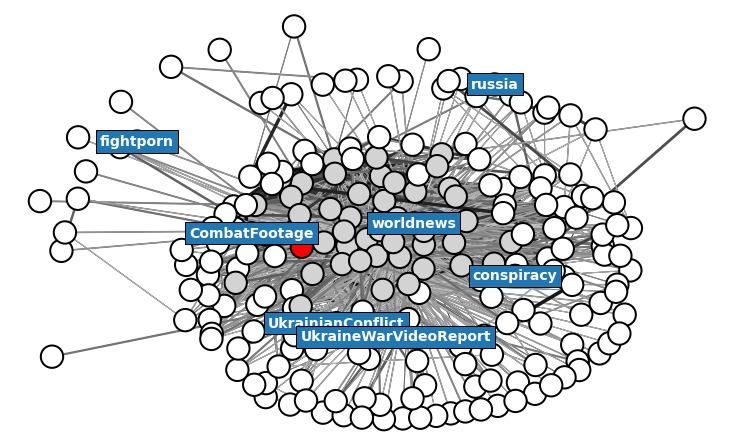

In [466]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

plt.figure(figsize=(10,6))

ego_network = nx.ego_graph(G, "ukraine")
nodes_ego1 = ego_network.nodes()
ego_network = nx.ego_graph(G, "ukraine", 2)


#pos = nx.spiral_layout(ego_network)  # Seed layout for reproducibility
#pos = nx.kamada_kawai_layout(ego_network)  # Seed layout for reproducibility
pos = graphviz_layout(ego_network, prog="neato")
weights = [ego_network[u][v]["weight"] for u,v in ego_network.edges()]

shortest1 = []
shortest2 = []

for k, v in shortest_paths.items():
    if k == "ukraine":
        continue
    if k in nodes_ego1:
        if len(shortest1) < 5:
            shortest1.append(k)
    else:
        if len(shortest2) < 5:
            shortest2.append(k)
    if len(shortest1) >= 5 and len(shortest2) >= 5:
        break


# weight and color of edges 
scaling_factor = 4 # to emphasise differences 
alphas = [weight * scaling_factor for weight in weights]
colors = [rgb_to_hex(tuple(np.repeat(int(255 * (1-weight)),3))) for weight in weights]

colormap = ["red" if node == "ukraine" else "lightgray" if node in nodes_ego1 else "white" for node in ego_network.nodes()]


#labelsdict = {node:node if node in nodes_ego1 and np.random.random() > 0.83 else node if np.random.random() > 0.97 else "" for node in ego_network.nodes()}
labelsdict = {node:node if node in relevant else "" for node in ego_network.nodes()}
#labelsdict = {node:node if (node in shortest1 or node in shortest2) else "" for node in ego_network.nodes()}

nx.draw(ego_network, 
        pos,
        #connectionstyle="arc3,rad=0.15",
        node_color=colormap, 
        node_size=500, 
        with_labels=False, 
        linewidths=2,
        #width=alphas, 
        edgecolors="black",
        font_weight="extra bold",
        font_color="red",
        font_size=20)
        #labels=labelsdict,
       #edge_color=colors)

nx.draw_networkx_edges(ego_network,
                        pos,
                       edge_color=colors,
                       #edgecolors="black",
                       width=alphas,
                       alpha=1,
                       connectionstyle="arc3,rad=0.15"
)

nx.draw_networkx_labels(ego_network,
                        pos,
                        font_weight="extra bold",
                        font_color="white",
                        font_size=14,
                        #edgecolor="white",
                        bbox= dict(lw=1),
                       labels=labelsdict)
plt.savefig("ego_network_ukraine_labels.pdf")
plt.show()

In [439]:
ego_network.nodes()

NodeView(('environment', 'sports', 'ukraine', 'marvelmemes', 'science', 'TikTokCringe', 'MadeMeSmile', 'LifeProTips', 'me_irl', 'LeopardsAteMyFace', 'Coronavirus', 'Cringetopia', 'Unexpected', 'PS5', 'MemeVideos', 'Tinder', 'relationship_advice', 'DnD', 'australia', 'gifs', 'IdiotsInCars', 'AskMen', 'meirl', 'soccer', 'AmItheAsshole', 'lostgeneration', 'unpopularopinion', 'weed', 'polls', 'OldSchoolCool', 'meme', 'RoastMe', 'lgbt', 'halo', 'tf2', 'russia', 'rareinsults', 'dndmemes', 'UpliftingNews', 'cats', '196', 'technology', 'news', 'cursedcomments', 'antiwork', 'dankmemes', 'CombatFootage', 'funny', 'AskReddit', 'apexlegends', 'canada', 'TooAfraidToAsk', 'Minecraft', 'pics', 'iamatotalpieceofshit', 'Music', 'AskAnAmerican', 'wallstreetbets', 'trashy', 'explainlikeimfive', 'teenagers', 'nextfuckinglevel', 'pcgaming', 'mildlyinteresting', 'atheism', 'shitposting', 'Animemes', 'BestofRedditorUpdates', 'DunderMifflin', 'SelfAwarewolves', 'technicallythetruth', 'Eldenring', 'TankPorn', 

In [465]:
relevant = ["worldnews", "UkrainianConflict", "UkraineWarVideoReport", "fightporn", "russia", "CombatFootage", "conspiracy"]

In [269]:
len(ego_network.nodes())

449

In [206]:
H = sorted(nx.connected_components(G), key=lambda n:len(n), reverse=True)[0]